## Results and Plotting
A notebook to compile results and organise plots and other resources needed for reporting

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set global plotting params here for consistency
plt.style.use('eeg_lib/styles.mplstyle')
palette = ['#0b528c', '#7170b6', '#b86eb2', '#ec7098', '#ff8572', '#ffaa4f']

from cycler import cycler
plt.rc('axes', prop_cycle=cycler('color', palette[::2]+palette[-1:]))

In [26]:
stim_freqs = [7,10,12] # stim freqs used
fs = 64 # sampling freq
Ns = 256 # number of sample points to consider
Nh = 1 # number of harmonics for CCA-based algos

index_pos = dict(zip(["Nc", "Ns", "Nt"], range(3)))

## Data Loading
Load data from json log files and arrange by frequency. The compiled data is stored in the dictionary `data` whose keys are the stimulus frequencies used and whose values are the data tensors corresponding to trials at those frequencies. Data tensors will be arranged like `Nc x Ns x Nt` (channels x samples x trials). 

Note that in this project, we only effectively had one channel. Also, all Nt trials would be independent recordings at the same stimulus frequency.


In [27]:
from eeg_lib.utils import read_json
import json

tests = {7: ["7hz"], 
         10: ["10hz"], 
         12: ["12hz"]
        }

all_data = read_json('/Users/rishil/Desktop/FYP/EEG-decoding/eeg_lib/logs/log_data_new.json')
data = {}

cleaned = { 7: [],
            10: [],
            12: []}

for f, test_set in tests.items():
    print(f,test_set)
    for key in all_data[test_set[0]]:
        cleaned[f].append(key['eeg_data'])
    print(len(cleaned[f]))
# print(cleaned)
for f, test_set in tests.items():
    data[f] = []
    if f == 7:
        cleaned[f] = cleaned[f][1:6]
    for test in cleaned[f]:
        values = test
        proc_data = np.array(values)
        data[f].append(proc_data.reshape((1, Ns, -1))) # exclude first trial
        
# del all_data    

for f, proc_data in data.items():
    if len(proc_data) <= 1:
        data[f] = proc_data[0]
    else:
        data[f] = np.concatenate([*proc_data], axis=-1) # merge data from across trials
    print(len(data))

7 ['7hz']
7
10 ['10hz']
6
12 ['12hz']
5
3
3
3


## Decoding
Run various decoding algos on gathered data and store results for comparison

### CCA
Vanilla CCA with no historical training data used across evaluations

In [5]:
from eeg_lib.cca import CCA

cca = CCA(stim_freqs, fs, Nh=Nh)

cca_results = {f:[] for f in stim_freqs}
cca_agg_results = {f:{} for f in stim_freqs}

for f in stim_freqs:
    data_f = data[f]
    for trial in range(1, data[f].shape[index_pos["Nt"]]):
        Xi = data_f[:, :, trial]
        result = cca.compute_corr(Xi)
        result = {k:np.round(v[0], 6) for k,v in result.items()}
        
        result['trial'] = f'f{f}_{trial}'
        result['y'] = f
        cca_results[f].append(result)
        
        # compute CCA result using data aggregated across trials
        agg_result = cca.compute_corr(data_f.mean(axis=index_pos["Nt"]))
        agg_result = {k:np.round(v[0], 6) for k,v in agg_result.items()}
        agg_result['y'] = f
        cca_agg_results[f] = agg_result
    
cca_df = pd.concat([pd.DataFrame(result_set) for result_set in cca_results.values()]).set_index('trial')
cca_df['y_hat'] = cca_df[stim_freqs].apply(lambda row: stim_freqs[np.argmax(row)], axis=1)

cca_agg_df = pd.DataFrame(list(cca_agg_results.values()))
cca_agg_df['y_hat'] = cca_agg_df[stim_freqs].apply(lambda row: stim_freqs[np.argmax(row)], axis=1)

cca_df

AttributeError: 'CCA' object has no attribute 'Y'

## Template-based Algorithms 
This section explores decoding algos that, along with potentially the artificially-generated harmonic reference, include template data based on historical 'training' data. These include GCCA, MsetCCA, TRCA and others.

In [28]:
min_trial_len = np.min([test_set.shape[-1] for test_set in data.values()])

# Nf x Nc x Ns x Nt
data_tensor = np.array([test_set[:, :, :min_trial_len] for test_set in data.values()])

print("Data tensor shape: ", data_tensor.shape)

Data tensor shape:  (3, 1, 256, 5)


In [29]:
from sklearn.model_selection import LeavePOut

N_train = 4
lpo = LeavePOut(p=N_train)

n_trials = data_tensor.shape[-1]
template_idxs = list(lpo.split(range(n_trials)))

#### GCCA
Generalised CCA aims to simultaneously maximise correlation between three sets of data: historical observations, measured signals in a new sample and the pre-constructed sinusoidal reference. As interpreted by the authors (Wong et al), the optimal spatial filters obtained through GCCA perform SSVEP signal denoising.

#### MsetCCA
MsetCCA is one extension of standard CCA that takes into account historical data instead of performing inference purely on new observations. Zhang et al propose that this is one of the reasons that standard CCA performs poorly on short time windows; it effectively over fits to localised dynamics. Furthermore, the authors suggest that exclusively using the pre-constructed sinusoidal reference set is not optimal since this artificial reference does not exclude other features from real EEG data. To circumvent this, MsetCCA seeks to optimise the reference signals used in the CCA algorithm by learning multiple linear transforms to maximise overall correlation between canonical variables over many sets of EEG data at each candidate frequency fk ∈ F. This optimisation effectively finds optimal joint spatial filters w1, . . . , wNt (over Nt trials) using only historical observations (‘training’ data). The authors claim that MsetCCA outperforms similar techniques, especially in cases with few channels and short time windows.

In [30]:
def softmax(X):
    exps = np.exp(X)
    return exps / np.sum(exps)

def cross_entropy(X, y):
    """
    source: https://deepnotes.io/softmax-crossentropy
    
    X is the output from fully connected layer (num_examples x num_classes)
    y is labels (num_examples x 1)
    """
    m = y.shape[0]
    p = softmax(X)
    log_likelihood = -np.log(p[range(m),y])
    loss = np.sum(log_likelihood) / m
    return loss

In [31]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

def compute_gcca_msetcca_results(gcca, mset_cca, data_tensor, stim_freqs, template_idxs, ce_loss=True):
    
    gcca_results = {f:[] for f in stim_freqs}
    mset_cca_results = {f:[] for f in stim_freqs}

    for f_idx, f in enumerate(stim_freqs):
        for split_idx, (test_idxs, train_idxs) in enumerate(template_idxs):
            chi_train = data_tensor[:, :, :, train_idxs]

            # train models on current train-test split
            gcca.fit(chi_train)
            mset_cca.fit(chi_train)

            # extract test matrices from all test indices and compute result
            for test_idx in test_idxs:
                if test_idx in train_idxs:
                    raise ValueError("Found intersection between train and test indices")
                    
                # note: we must match the number of samples Ns in chi_train
                X_test = data_tensor[f_idx, :, :, test_idx]
                
                _idx = f'f{f}_split{split_idx+1}_test{test_idx+1}'
                test_meta = {'idx': _idx, 'y': f, 'test': test_idx, 'split': split_idx}
                
                # GCCA
                result = {k: abs(np.round(v,4)) for k,v in gcca.classify(X_test).items()}
                gcca_results[f].append({**result, **test_meta})

                # MsetCCA
                result = {k: abs(np.round(v,4)) for k,v in mset_cca.classify(X_test).items()}
                mset_cca_results[f].append({**result, **test_meta})
                
    def _prep_results_df(results):
        df = pd.concat([pd.DataFrame(result_set) for result_set in results.values()])
        df['y_hat'] = df[stim_freqs].apply(lambda row: stim_freqs[np.argmax(row)], axis=1)
        df = df.set_index(['y', 'split'])
        
        if ce_loss:
            # compute cross entropy loss
            for f_idx, f in enumerate(stim_freqs):
                result = df.loc[f, stim_freqs].apply(lambda row: cross_entropy(row.values.reshape(1, -1), np.array([f_idx])), axis=1)
                df.loc[(f, ), 'ce_loss'] = result.values
                
        df['correct'] = df.index.get_level_values(level=0) == df.y_hat

        return df

    gcca_df = _prep_results_df(gcca_results)
    mset_df = _prep_results_df(mset_cca_results)
    
    return gcca_df, mset_df

def decoding_acc(result_df):
    acc = result_df['correct'].groupby(['y', 'split']).apply(lambda x: np.sum(x)/len(x))
    acc_grouped = acc.groupby('y')
    acc_av = acc_grouped.mean().to_dict()
    acc_std = acc_grouped.std().to_dict()
    return {'raw': acc, 'mean': acc_av, 'std': acc_std}

gcca = GCCA_SSVEP(stim_freqs, fs, Nh=Nh)
mset_cca = MsetCCA_SSVEP(stim_freqs)

gcca_df, mset_cca_df = compute_gcca_msetcca_results(gcca, mset_cca, data_tensor, stim_freqs, template_idxs)
gcca_acc = decoding_acc(gcca_df)
mset_acc = decoding_acc(mset_cca_df)

print("GCCA: ", gcca_acc['mean'])
print("MsetCCA: ", mset_acc['mean'])

print(mset_cca_df)

GCCA:  {7: 0.2, 10: 0.2, 12: 1.0}
MsetCCA:  {7: 0.8, 10: 0.8, 12: 1.0}
               7      10      12               idx  test  y_hat   ce_loss  \
y  split                                                                    
7  0      0.3529  0.1305  0.3493   f7_split1_test5     4      7  1.028548   
   1      0.3008  0.2309  0.1388   f7_split2_test4     3      7  1.023504   
   2      0.2648  0.1058  0.1613   f7_split3_test3     2      7  1.013299   
   3      0.2849  0.1701  0.1206   f7_split4_test2     1      7  1.007970   
   4      0.1193  0.3018  0.2355   f7_split5_test1     0     10  1.200999   
10 0      0.1249  0.2817  0.3082  f10_split1_test5     4     12  1.058391   
   1      0.2984  0.3692  0.2217  f10_split2_test4     3     10  1.027657   
   2      0.1669  0.3559  0.2366  f10_split3_test3     2     10  0.998913   
   3      0.1376  0.2792  0.1832  f10_split4_test2     1     10  1.021167   
   4      0.1959  0.3231  0.2180  f10_split5_test1     0     10  1.022736   
12 0 

### Tests to explore

Some ideas for interesting tests/factors to investigate. 

#### Preliminary and verification tests
- alpha band tests from Adrian data: periodograms of eyes open vs closed
- verification tests using square wave input and filtering both on-device and offline. 
- verification tests to demonstrate equivalence of downsampling and to show the effect of aliasing without filtering
- (possibly included in above two) show periodograms of original unfiltered, filtered and filtered + downsampling

#### Main results

Test the effect of the following on decoding accuracy:
1. number of training trials
2. number of samples in each window (Ns)
3. number of stimulus frequencies

other miscellaneous tests:
- [] generalisation performance on different set of data: both with pretraining from diff sets and without
- [] average accuracy per stimulus frequency
- [] deviation between accuracy of diff frequencies for each trial/test for different algos ** NB
- [] average accuracy per stimulus square configuration (wide, narrow etc) * optional
- [] some meausre of inter-trial consistency 
- [] some measure of similarity between estimated outputs: e.g. log loss that penalises similar outputs
- [] measure of ITR taking into account Ns per window and overlap between window
- [] comparison of periodogram that can't distinguish SSVEP vs CCA that can

#### 1. Acc vs number of training trials

In [10]:
Ns = 256

# Nf x Nc x Ns x Nt
data_tensor = np.array([test_set[:,:Ns,:min_trial_len] for test_set in data.values()])

print("Data tensor shape: ", data_tensor.shape)

Data tensor shape:  (3, 1, 256, 6)


In [11]:
n_trials = data_tensor.shape[-1]
gcca_ntr_acc = []
mset_ntr_acc = []

for n_train in range(1, n_trials):
    lpo = LeavePOut(p=n_train)
    template_idxs_tmp = list(lpo.split(range(n_trials)))

    data_tensor_tmp = data_tensor[:, :, :Ns, :]
    gcca_df, mset_cca_df = compute_gcca_msetcca_results(gcca, mset_cca, data_tensor_tmp, stim_freqs, template_idxs_tmp)

    _gcca_acc = decoding_acc(gcca_df)
    _mset_acc = decoding_acc(mset_cca_df)
    
    # store these values for easy plotting
    gcca_ntr_acc.append({**_gcca_acc['mean'], **{"n_train": n_train}})
    mset_ntr_acc.append({**_mset_acc['mean'], **{"n_train": n_train}})    
    
acc_ntr_gcca = pd.DataFrame(gcca_ntr_acc).set_index("n_train")
acc_ntr_mset = pd.DataFrame(mset_ntr_acc).set_index("n_train")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

NameError: name 'acc_ntr_gcca' is not defined

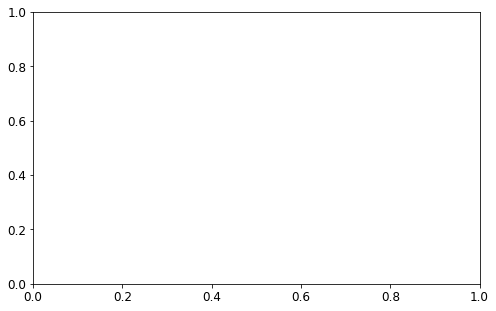

In [12]:
from eeg_lib.plotting import grouped_bar

legend = [f'{f}Hz' for f in stim_freqs]

fig0, ax0 = plt.subplots(1, figsize=(8,5))
_, ax0 = grouped_bar(acc_ntr_gcca.index, acc_ntr_gcca.values*100, xlabel='Training trials', ylabel='Accuracy (%)', ax=ax0)

fig1, ax1 = plt.subplots(1, figsize=(8,5))
_, ax1 = grouped_bar(acc_ntr_mset.index, acc_ntr_mset.values*100, xlabel='Training trials', ylabel='Accuracy (%)', ax=ax1, colors=palette[1::2])

for ax in [ax0, ax1]:
    ax.set_yticks(np.arange(20, 110, step=10))
    ax.set_ylim(20, 110)
    ax.legend(legend, ncol=3, loc='upper left')
    
ax0.plot(ax0.get_xticks(), acc_ntr_gcca.mean(axis=1)*100, marker='x', c='k', ls='-.', alpha=0.7)
ax1.plot(ax1.get_xticks(), acc_ntr_mset.mean(axis=1)*100, marker='x', c='k', ls='-.', alpha=0.7)

# save figs
fig0.savefig(f'plots/acc_Nt_gcca_Ns{Ns}.pdf', format='pdf')
fig1.savefig(f'plots/acc_Nt_mcca_Ns{Ns}.pdf', format='pdf')

#### 2. Acc vs number of samples

In [13]:
N_train = 4

lpo = LeavePOut(p=N_train)

n_trials = data_tensor.shape[-1]
template_idxs = list(lpo.split(range(n_trials)))

assert data_tensor.shape[-2] == 256, "Expected data tensor to have full Ns=256 samples"

In [14]:
ns_range = [32, 48, 64, 128, 256]
gcca_acc = []
mset_acc = []

for ns in ns_range:
    data_tensor_tmp = data_tensor[:, :, :ns, :]
    gcca_df, mset_cca_df = compute_gcca_msetcca_results(gcca, mset_cca, data_tensor_tmp, stim_freqs, template_idxs, ce_loss=False)
    _gcca_acc = decoding_acc(gcca_df)
    _mset_acc = decoding_acc(mset_cca_df)
    
    # store these values for easy plotting
    gcca_acc.append({**_gcca_acc['mean'], **{"Ns": ns}})
    mset_acc.append({**_mset_acc['mean'], **{"Ns": ns}})
    
acc_ns_gcca = pd.DataFrame(gcca_acc).set_index("Ns")
acc_ns_mset = pd.DataFrame(mset_acc).set_index("Ns")

/Users/rishil/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/rishil/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:353: UserWarning: X scores are null at iteration 0
  warnings.warn('X scores are null at iteration %s' % k)
/Users/rishil/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/rishil/opt/anaconda3/lib/python3.8/site-packages/sklearn/cross_decomposition/_pls.py:353: UserWarning: X scores are null at iteration 0
  warnings.warn('X scores are null at iteration %s' % k)
/Users/rishil/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is const

TypeError: grouped_bar() got an unexpected keyword argument 'colors'

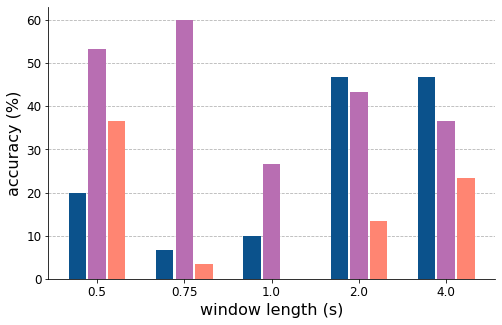

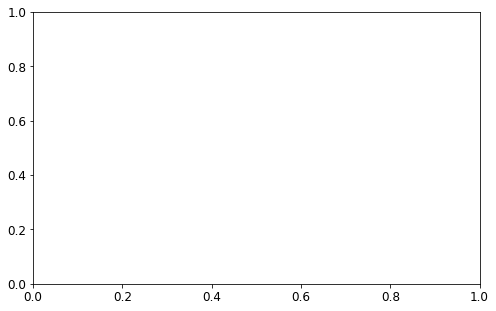

In [15]:
from eeg_lib.plotting import grouped_bar

legend = [f'{f}Hz' for f in stim_freqs]
t_ax = acc_ns_gcca.index/fs

fig0, ax0 = plt.subplots(1, figsize=(8,5))
_, ax0 = grouped_bar(t_ax, acc_ns_gcca.values*100, xlabel='window length (s)', ylabel='accuracy (%)', ax=ax0)

fig1, ax1 = plt.subplots(1, figsize=(8,5))
_, ax1 = grouped_bar(t_ax, acc_ns_mset.values*100, xlabel='window length (s)', ylabel='accuracy (%)', ax=ax1, colors=palette[1::2])

for ax in [ax0, ax1]:
    ax.set_ylim(20, 110)
    ax.set_yticks(np.arange(20, 110, step=10))
    ax.legend(legend, ncol=3)
    
ax0.plot(ax0.get_xticks(), acc_ns_gcca.mean(axis=1)*100, marker='x', c='k', ls='-.', alpha=0.7)
ax1.plot(ax1.get_xticks(), acc_ns_mset.mean(axis=1)*100, marker='x', c='k', ls='-.', alpha=0.7)
# ax1.legend(loc='upper left')

fig0.savefig(f'plots/acc_Ns_gcca_Nt{N_train}.pdf', format='pdf')
fig1.savefig(f'plots/acc_Ns_mcca_Nt{N_train}.pdf', format='pdf')

## Alpha Band Tests
Tests using the 'frankenstein' headset: opening vs closing eyes and looking at energy in the alpha band. No SSVEP, only eyes closed vs eyes open. The section below explores whether the difference in energy in the alpha band (9-10Hz) can be distinguished between these two events

In [ ]:
import glob

path = 'data/adrien/*' # Adrien data from Imperial
all_files = glob.glob(path)

closed_lbls = ['1053', '1254', '1258', '1259', '1730']
open_lbls = ['1052', '1256', '1257', '1732', '1731']

closed_data = {k:[] for k in closed_lbls}
open_data = {k: [] for k in open_lbls}

for filename in all_files:
    print(f"Loading file {filename}")
    data = pd.read_csv(filename, delimiter = "\n").values
    lbl = filename.split('/')[-1][:4]
    if lbl in closed_lbls:
        closed_data[lbl] = data
    elif lbl in open_lbls:
        open_data[lbl] = data
    else:
        print("warning: unknown label encountered: ", lbl)
        
# create data matrices
start = 0
N = 6000
Xo = np.squeeze(np.array([d[start:N] for d in open_data.values()]))
Xc = np.squeeze(np.array([d[start:N] for d in closed_data.values()]))

In [ ]:
np.append(np.arange(2), np.arange(4))

In [ ]:
from eeg_lib.freq_analysis import plot_periodogram


Ndft = 1024

fig0, axes = plt.subplots(1,2, figsize=(16,4))
for i in range(min(Xo.shape[0], 4)):
    plot_periodogram(Xo[i, :], 250, N=Ndft, axes=axes, show_titles=False)
    for ax in axes:
        xticks = np.append(np.arange(0, 24, step=4), np.arange(30, 130, step=10))
        ax.set_xticks(xticks)
        ax.set_xlim(0, 60)
        ax.grid(1)

fig1, axes = plt.subplots(1,2, figsize=(16,4))
for i in range(min(Xc.shape[0], 4)):
    plot_periodogram(Xc[i, :], 250, N=Ndft, axes=axes, show_titles=False)
    for ax in axes:
        xticks = np.append(np.arange(0, 24, step=4), np.arange(30, 130, step=10))
        ax.set_xticks(xticks)
        ax.set_xlim(0, 60)
        ax.grid(1)

plt.tight_layout(pad=2)

fig0.savefig(f'plots/eyes_open_alpha_spectra_N1024.pdf', format='pdf')
fig1.savefig(f'plots/eyes_closed_alpha_spectra_N1024.pdf', format='pdf')

## DSP and Filtering
Verification tests and demonstration plots of the digital signal processing system including sampling, filtering and downsampling 

In [ ]:
import numpy as np

# data collected from device and copied over
x = np.array([2958, 2958, 2957, 2957, 2956, 2955, 2957, 2954, 2955, 2952, 2955, 2955, 2955, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2950, 2951, 2958, 2958, 2955, 2958, 2959, 2956, 2957, 2954, 2953, 2955, 2955, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2959, 2949, 2958, 2957, 2955, 2958, 2958, 2958, 2957, 2960, 2956, 2958, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2955, 2955, 2949, 2959, 2957, 2957, 2959, 0, 0, 0, 0, 0, 0, 2958, 2956, 2957, 2958, 2956, 2956, 2957, 2957, 2957, 2954, 2958, 2957, 2954, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2957, 2955, 2958, 2954, 2955, 2955, 2955, 2956, 2955, 2956, 2956, 2957, 2958, 2955, 2957, 2954, 2955, 2956, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2957, 2957, 2953, 2956, 2955, 2956, 2955, 2951, 2956, 2955, 2955, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2957, 2956, 2957, 2956, 2954, 2953, 2955, 2954, 2954, 2955, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2958, 2956, 2955, 2948, 2947, 2949, 2949, 2950, 2950, 2949, 2951, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2950, 2960, 2957, 2955, 2957, 2955, 2956, 2956, 2955, 2949, 2958, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2959, 2956, 2957, 2957, 2955, 2956, 2957, 2953, 2957, 2955, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2955, 2956, 2954, 2956, 2955, 2955, 2959, 2957, 2959, 2955, 2957, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2947, 2957, 2957, 2957, 2957, 2955, 2957, 2955, 2957, 2959, 2954, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2959, 2947, 2949, 2957, 2955, 2957, 2955, 2957, 2955, 2954, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2956, 2956, 2956, 2955, 2958, 2955, 2947, 2955, 2955, 2954, 2955, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2954, 2955, 2954, 2954, 2954, 2957, 2957, 2957, 2955, 2954, 2953, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2955, 2954, 2954, 2956, 2956, 2955, 2955, 2955, 2955, 2955, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2955, 2954, 2953, 2959, 2955, 2953, 2953, 2954, 2954, 2955, 2955, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2946, 2949, 2957, 2955, 2957, 2955, 2957, 2954, 2954, 2954, 2954, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2958, 2955, 2958, 2956, 2947, 2947, 2959, 2957, 2954, 2955, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2956, 2955, 2955, 2955, 2954, 2958, 2955, 2955, 2954, 2954, 2958, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2958, 2957, 2957, 2954, 2955, 2953, 2955, 2954, 2955, 2955, 2954, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2957, 2954, 2956, 2955, 2958, 2953, 2954, 2958, 2957, 2954, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2960, 2959, 2957, 2956, 2955])
x_filt = np.array([0.749196, 3.908255, 13.0332, 33.75168, 74.19135, 143.8398, 251.7594, 403.9336, 600.2468, 832.0441, 1081.352, 1322.543, 1526.632, 1665.978, 1720.654, 1681.619, 1552.216, 1344.726, 1075.958, 761.6009, 412.4424, 34.32355, -367.9954, -784.6752, -1195.291, -1567.171, -1858.14, -2026.219, -2040.636, -1892.818, -1600.272, -1203.909, -757.1008, -310.811, 99.62306, 461.0332, 779.7377, 1070.83, 1344.146, 1591.823, 1785.632, 1883.173, 1843.527, 1643.573, 1290.803, 824.8954, 307.5806, -195.4421, -633.4667, -983.0684, -1248.915, -1453.266, -1617.797, -1748.471, -1827.711, -1820.265, -1687.84, -1408.848, -992.4298, -480.982, 60.30604, 562.8889, 975.2727, 1275.97, 1472.389, 1589.003, 1647.875, 1653.422, 1586.326, 1412.569, 1101.961, 648.6098, 83.82756, -525.262, -1092.073, -1536.016, -1807.126, -1898.597, -1844.595, -1701.702, -1524.497, -1343.015, -1154.069, -927.7673, -628.1702, -236.8592, 228.018, 708.0454, 1115.551, 1358.223, 1367.998, 1122.733, 656.8385, 55.53807, -562.1059, -1068.897, -1355.27, -1350.591, -1036.85, -453.1934, 309.2564, 1122.147, 1843.193, 2343.682, 2537.647, 2402.415, 1986.118, 1394.877, 763.7885, 217.1265, -168.9627, -387.8038, -498.8448, -599.5381, -782.0648, -1091.315, -1499.706, -1912.361, -2199.209, -2244.886, -1994.219, -1477.429, -802.1463, -115.464, 448.9626, 817.4392, 997.4481, 1065.081, 1124.483, 1257.106, 1483.085, 1751.796, 1965.967, 2028.798, 1891.546, 1581.914, 1196.507, 861.6956, 676.5399, 665.5295, 761.1139, 826.5695, 711.8249, 319.9014, -342.53, -1155.07, -1917.295, -2416.985, -2504.126, -2144.565, -1430.574, -545.6141, 301.8329, 948.8148, 1325.603, 1462.156, 1456.248, 1416.701, 1409.964, 1430.325, 1408.001, 1247.769, 880.3521, 303.1651, -407.8372, -1120.395, -1691.015, -2015.695, -2062.177, -1873.689, -1541.763, -1164.305, -806.1368, -479.7798, -153.673, 217.907, 657.1622, 1137.942, 1583.034, 1887.908, 1958.225, 1747.653, 1277.931, 633.6777, -65.30362, -702.415, -1197.748, -1522.652, -1693.914, -1750.008, -1724.48, -1626.681, -1440.83, -1140.695, -712.3898, -173.5533, 421.0309, 990.8127, 1451.84, 1742.725, 1840.331, 1761.534, 1548.812, 1249.857, 899.108, 510.2408, 82.31149, -384.698, -872.298, -1335.742, -1708.274, -1919.121, -1915.536, -1682.382, -1249.144, -682.2899, -66.37628, 518.4391, 1014.033, 1389.916, 1639.012, 1765.0, 1771.21, 1654.359, 1408.556, 1034.956, 552.0494, 0.5509186, -560.771, -1067.618, -1464.783, -1719.142, -1822.964, -1789.297, -1639.8, -1393.969, -1063.234, -653.3639, -173.61, 352.7622, 881.478, 1350.846, 1693.096, 1852.253, 1799.121, 1540.224, 1115.384, 585.957, 18.78627, -527.9962, -1012.701, -1408.62, -1698.592, -1867.34, -1899.107, -1779.896, -1505.941, -1091.951, -574.9527, -10.71037, 537.0494, 1011.044, 1371.511, 1602.0, 1705.169, 1693.714, 1578.701, 1363.871, 1046.966, 628.1962, 121.6132, -436.864, -988.3981, -1461.434, -1787.318, -1918.271, -1838.37, -1566.332, -1147.605, -640.2653, -100.717, 425.5685, 905.9919, 1315.357, 1629.974, 1823.184, 1868.277, 1745.666, 1453.717, 1015.783, 479.9271, -89.72442, -627.472, -1081.133, -1420.574, -1638.976, -1744.238, -1747.645, -1653.041, -1454.619, -1142.69, -715.5066, -191.4045, 385.2965, 947.2011, 1417.992, 1730.166, 1842.37, 1747.342, 1470.677, 1059.806, 569.0621, 47.20063, -468.3088, -949.5639, -1370.684, -1702.33, -1909.901, -1960.115, -1831.156, -1524.433, -1070.143, -523.8008, 45.79834, 573.1322, 1010.862, 1336.077, 1548.229, 1657.721, 1673.528, 1593.536, 1405.125, 1094.062, 658.3486, 120.3818, -469.0839, -1036.827, -1503.954, -1804.745, -1903.091, -1797.983, -1519.424, -1115.446, -636.9947, -127.0803, 382.2641, 865.8003, 1296.396, 1640.212, 1857.026, 1909.417, 1774.755, 1457.275, 992.245, 440.1387, -127.6881, -646.6767, -1073.474, -1390.289, -1600.469, -1715.31, -1741.317, -1671.724, -1489.221, -1176.995, -733.7028, -185.2801, 412.7588, 983.3976, 1446.616, 1738.687, 1827.641, 1716.814, 1438.771, 1041.185, 571.9446, 69.75678, -436.8962, -923.9557, -1362.59, -1715.2, -1937.501, -1989.561, -1848.939, -1522.626, -1049.942, -494.8359, 69.99933, 581.3898, 999.4244, 1310.228, 1519.756, 1639.46, 1673.521, 1611.461, 1432.585, 1118.534, 668.9295, 112.6879, -491.0679, -1062.738, -1521.894, -1806.732, -1888.617, -1774.111, -1497.437, -1105.637, -644.0118, -147.9083, 356.7983, 846.7686, 1291.734, 1651.211, 1877.911, 1930.134, 1785.639, 1453.423, 975.6357, 418.5621, -144.3174, -650.8964, -1063.633, -1371.184, -1581.022, -1704.406, -1743.746, -1686.06, -1508.594, -1192.323, -737.895, -176.4526, 430.4875, 1001.861, 1457.363, 1736.812, 1813.947, 1697.354, 1422.029, 1034.219, 577.2637, 84.31768, -420.1548, -912.8057, -1361.973, -1725.065, -1952.972, -2003.302, -1854.578, -1517.661, -1036.804, -479.6651, 80.25444, 582.1897, 990.6888, 1296.302, 1507.35, 1634.53, 1678.551, 1624.372, 1447.745, 1129.373, 670.9375, 105.4227, -503.8624, -1074.914, -1527.742, -1803.556, -1877.882, -1760.654, -1487.153, -1102.729, -649.0684, -157.6962, 347.7664, 843.6277, 1296.841, 1663.01, 1891.617, 1939.894, 1787.196, 1446.059, 962.5132, 405.3255, -152.0406, -649.9646, -1054.725, -1358.423, -1570.085, -1699.991, -1747.533, -1696.063, -1520.16, -1200.279, -738.8603, -170.2697, 440.816, 1011.653, 1462.445, 1735.41, 1807.41, 1689.435, 1417.07, 1035.104, 584.0834, 94.34014, -411.2118, -908.8039, -1364.591, -1733.045, -1962.697, -2010.432, -1855.975])

x_filt_mac = signal.sosfilt(sos_ellip, x)

x = x-np.mean(x)

In [ ]:
sig = x[150:]
sig_filt = x_filt[150:]

adc_to_v = lambda x: 3.6*(x/(2**12-1))

t_ax = np.arange(len(sig))/256

sig_ideal = (4/np.pi)*np.sin(2*np.pi*12*t_ax)

fig, ax0 = plt.subplots(1, figsize=(14,5))
ax0.plot(t_ax, adc_to_v(sig))
ax0.plot(t_ax, adc_to_v(sig_filt))
ax0.plot(t_ax, sig_ideal)

ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

ax0.set_xlabel('time (s)')
ax0.set_ylabel('amplitude (V)')
ax0.set_ylim(-2, 2.2)
ax0.axhline(0, c='k', lw='0.5', ls='-.', alpha=0.3)

ax0.legend(['$x\,[n]$', '$y\,[n]$', '$y^*[n]$'], ncol=3,loc='upper right', fontsize=14)
plt.savefig('plots/sq_wave_filtering_time.pdf', format='pdf')

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18,5))
# plot_periodogram(x_filt_ds, 64, N=256, figsize=(14, 8), axes=axes)
plot_periodogram(x, 256, N=512, figsize=(10, 8), axes=axes, show_titles=False)
plot_periodogram(x_filt, 256, N=512, axes=axes, show_titles=False)
# plot_periodogram(x_ds_no_filt, 64, N=256, figsize=(14, 8), axes=axes)

for ax in axes:
    ax.legend(['$\hat{P}_x\,(\omega)$', '$\hat{P}_y\,(\omega)$'], fontsize=19, ncol=2, loc='upper right')
    ax.axvline(12, ls='-.', alpha=0.75, c='k')
    ax.axvline(36, ls='-.', alpha=0.5, c='k')
    ax.axvline(60, ls='-.', alpha=0.25, c='k')
    ax.axvline(7*12, ls='-.', alpha=0.15, c='k')
    ax.set_xticks(np.arange(0, 134, step=12))
    ax.grid(1)

plt.tight_layout(pad=1.8)
plt.savefig('plots/sq_wave_filtering_spectra.pdf', format='pdf')

In [ ]:
x_ds = x_filt[::4]
x_ds_no_filt = x[::4]

fig, axes = plt.subplots(1,2, figsize=(18,5))

plot_periodogram(x, 256, N=512, axes=axes, show_titles=False)
plot_periodogram(x_ds, 64, N=512, figsize=(10, 8), axes=axes, show_titles=False)
plot_periodogram(x_ds_no_filt, 64, N=512, axes=axes, show_titles=False)

for ax in axes:
    ax.grid(b=1)
    ax.legend(['$\hat{P}_x\,(\omega)$', '$\hat{P}_z\,(\omega)$', '$\hat{P}_{alias}\,(\omega)$'], fontsize=18, ncol=3, loc='lower left')
    ax.set_xlim(0, 34)
    
plt.savefig('plots/sq_wave_filtering_ds_spectra.pdf', format='pdf')

In [ ]:
from scipy import signal

fs = 256
filt_ord = 10
pb_rip = 0.2
sb_atten = 80

fc_lo = 4 # pass band lower freq
fc_hi = 28 # pass band upp freq 
wc_lo = fc_lo/(fs*0.5)
wc_hi = fc_hi/(fs*0.5)


# sos_ellip = signal.ellip(filt_ord, pb_rip, sb_atten, (wc_lo, wc_hi), btype='bandpass', output='sos')
sos_ellip = signal.ellip(filt_ord, pb_rip, sb_atten, wc_hi, btype='lowpass', output='sos')
sos_cheby2 = signal.cheby2(filt_ord, sb_atten, wc_hi, btype='lowpass', output='sos')
sos_cheby1 = signal.cheby1(filt_ord, pb_rip, wc_hi, btype='lowpass', output='sos')
sos_bw = signal.butter(10, [1, 28], 'bp', fs=256, output='sos')

w, h_ellip = signal.sosfreqz(sos_ellip, worN=512)
_, h_cheby1 = signal.sosfreqz(sos_cheby1, worN=512)
_, h_cheby2 = signal.sosfreqz(sos_cheby2, worN=512)

# plot frequency response

fig_mag = plt.figure(figsize=(14,8))
plt.subplot(2, 1, 1)
db = 20*np.log10(np.maximum(np.abs(h_ellip), 1e-5))
plt.plot(w/np.pi, db, label='elliptical')

db = 20*np.log10(np.maximum(np.abs(h_cheby1), 1e-5))
plt.plot(w/np.pi, db, label='cheby. type I')

db = 20*np.log10(np.maximum(np.abs(h_cheby2), 1e-5))
plt.plot(w/np.pi, db, label='cheby. type II')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.ylim(-100, 5)
plt.grid(True)
plt.yticks([0, -8, -20, -40, -80, -100])
plt.axvline(50/128, ls='-.', c='k', label='50Hz at $f_s=256$Hz', alpha=0.7)
plt.ylabel('Gain (dB)')
# plt.title('Frequency Response')
plt.legend(ncol=4, fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(w/np.pi, np.angle(h_ellip), label='elliptical')
plt.plot(w/np.pi, np.angle(h_cheby1), label='cheby. type I', alpha=0.4)
plt.plot(w/np.pi, np.angle(h_cheby2), label='cheby. type II', alpha=0.4)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.grid(True)
plt.axvline(50/128, ls='-.', c='k', label='50Hz at $f_s=256$Hz', alpha=0.7)

plt.yticks([-np.pi, -0.5*np.pi, 0, 0.5*np.pi, np.pi],
           [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
plt.ylabel('Phase (rad)')
plt.xlabel('Normalized frequency (1.0 = Nyquist)')

plt.legend(ncol=4, fontsize=14)    

plt.tight_layout(pad=1.8)
plt.savefig('plots/digital-filt-resp.pdf', format='pdf')